# Assignment 3: 2D Multi-Element Airfoil

In this assignment we'll use the vortex-source panel method to simulate the flow over an airfoil with multiple elements. As usual, we'll start by importing our trusted libraries and by running definitions.ipynb which defines the Freestream and Panel classes.

In [1]:
import numpy
import math
import os
from scipy import integrate, linalg
from matplotlib import pyplot

%matplotlib inline
%run ./definitions.ipynb

## Part 1: William's test case

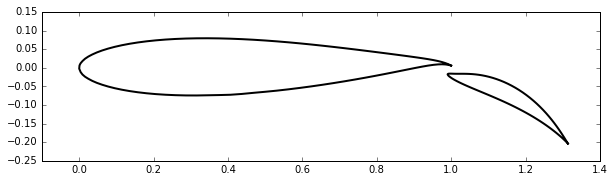

In [2]:
main_filepath = os.path.join('resources', 'MainFoil_N=100.csv')
with open (main_filepath, 'r') as file_name:
    xm, ym = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)
    
flap_filepath = os.path.join('resources', 'FlapFoil_N=100.csv')
with open (flap_filepath, 'r') as file_name:
    xf, yf = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

# plot to view geometry (and to check we imported the data correctly)
size = 10
pyplot.figure(figsize=(size, size))
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-0.25, 0.15)
pyplot.plot(xm, ym, xf, yf, color='k', linestyle='-', linewidth=2);

We can simply create the panels using the data we loaded because the geometry has already been discretized 

In [3]:
def define_panels(x, y):
    """
    Creates panels form discretized geometry.
    
    Parameters
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    
    Returns
    -------
    panels: 1D numpy array of Panel objects
        The list of panels.
    """
    N = len(x)-1
    x_ends, y_ends = x, y
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
        
    return panels

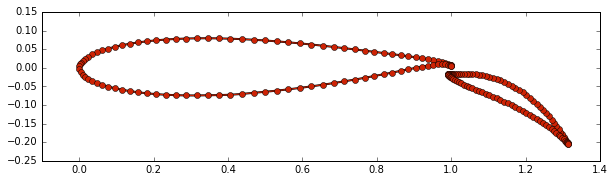

In [4]:
main_panels = define_panels(xm, ym)
flap_panels = define_panels(xf, yf)
panels = numpy.append(main_panels, flap_panels)

size = 10
pyplot.figure(figsize=(size, size))
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-0.25, 0.15)
pyplot.plot(xm, ym, xf, yf, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in main_panels], main_panels[0].xa),
            numpy.append([panel.ya for panel in main_panels], main_panels[0].ya),
            numpy.append([panel.xa for panel in flap_panels], flap_panels[0].xa),
            numpy.append([panel.ya for panel in flap_panels], flap_panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305');

Just like lesson 11, we'll be using the vortex-source panel method which means we've got a lot of functions to define.

In [5]:
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution of a panel at one point.
    
    Parameters
    ----------
    x: float 
        x_coordinate of the target point.
    y: float
        y_coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contributions from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [6]:
def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D numpy array of floats
        Source contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i!=j:
                A[i,j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc,
                                               panel_j, numpy.cos(panel_i.beta),
                                               numpy.sin(panel_i.beta))
    return A

In [7]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
        
    Returns
    -------
    A: 2D numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i!=j:
                A[i,j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc,
                                               panel_j, numpy.sin(panel_i.beta),
                                               -numpy.cos(panel_i.beta))
    return A

Instead of defining the Kutta condition as a separate function, we'll build the entire tangential velocity matrix in the function below then use the rows we need to satisfy the Kutta condition for both the main and flap airfoils.

In [9]:
def build_singularity_matrix(panels, A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    N = panels.size
    
    # build the tangential velocity contribution matrix
    A_t = numpy.empty((N, N+2), dtype=float)
   
    # matrix of source contribution on tangential velocity
    # is the same as the
    # matrix of vortex contribution on normal velocity
    A_t[:N,:N] = B_vortex
    
    # matrix of vortex contribution on tangential velocity
    # is the opposite of the
    # matrix of source contribution on normal velocity
    A_t_penult, A_t_ult = numpy.zeros((N), dtype=float), numpy.zeros((N), dtype=float)
    for i, panels_i in enumerate(panels):
        A_t_penult[i] = numpy.sum(A_source[i,:int(N/2)])
        A_t_ult[i] = numpy.sum(A_source[i,int(N/2):])
    
    A_t[:, -2] = -A_t_penult
    A_t[:, -1] = -A_t_ult
    
    # build the matrix of the linear system
    A = numpy.empty((N+2, N+2), dtype=float)
    
    # source contribution matrix
    A[:N, :N] = A_source
    
    # vortex contribution array
    A_v = numpy.empty((N,2), dtype=float)
    for i, panel_i in enumerate(panels):
        A_v[i,0] = numpy.sum(B_vortex[i,:int(N/2)])
        A_v[i,1] = numpy.sum(B_vortex[i,int(N/2):])
    
    A[:N, N:] = A_v

    # Kutta condition array
    A_k = numpy.empty((2,N+2), dtype=float)
    A_k[0,:] = A_t[0,:] + A_t[int(N/2-1),:]
    A_k[1,:] = A_t[int(N/2),:] + A_t[-1,:]
    
    A[-2:, :] = A_k
    
    return A

Again straying slightly from the code we used in class with just one airfoil, we adjust the right-hand side of the linear system to compute two seperate vortex strengths, one for the main foil and one for the flap foil.

In [10]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    N = panels.size
    b = numpy.empty(N+2,dtype=float)
    
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    
    # freestream contribution on the Kutta condition for the main airfoil
    b[-2] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[int(N/2-1)].beta) )
    
    # freestream contribution on the Kutta condition for the flap airfoil
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[int(N/2)].beta)
                               +numpy.sin(freestream.alpha-panels[N-1].beta) )
    
    return b

Now we can solve our linear system!

In [11]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

In [12]:
u_inf = 1.0
alpha = 0.0
freestream = Freestream(u_inf, alpha)

In [13]:
A = build_singularity_matrix(panels, A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:50: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:56: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__

In [14]:
# solve for singularity strengths
strengths = numpy.linalg.solve(A, b)

# store source strength on each panel
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-2:]

Before we can actually interpret the results of this, we still have a couple more functions we need to define. 

To compute the tangential velocity, we build the contribution matrix the same way we did to satisfy the Kutta condition. Once we have that, we can use the same function to get the pressure coefficient that we used in class!

In [15]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    N = panels.size
    A = numpy.empty((N, N+2), dtype=float)
   
    # matrix of source contribution on tangential velocity
    # is the same as the
    # matrix of vortex contribution on normal velocity
    
    A[:N,:N] = B_vortex
    
    # matrix of vortex contribution on tangential velocity
    # is the opposite of the
    # matrix of source contribution on normal velocity
    A_penult, A_ult = numpy.zeros((N), dtype=float), numpy.zeros((N), dtype=float)
    for i, panels_i in enumerate(panels):
        A_penult[i] = numpy.sum(A_source[i,:N/2])
        A_ult[i] = numpy.sum(A_source[i,N/2:])
    
    A[:, -2] = -A_penult
    A[:, -1] = -A_ult
    
    # freestream contribution
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [16]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [18]:
# tangential velocity at each panel center.
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
# surface pressure coefficient
compute_pressure_coefficient(panels, freestream)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [20]:
N = panels.size
main_panels, flap_panels = panels[:int(N/2)], panels[int(N/2):]

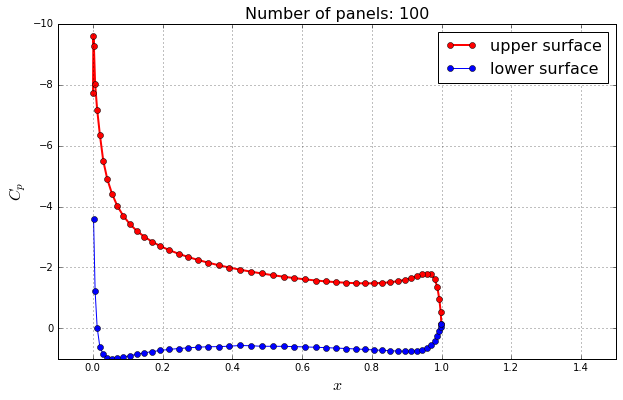

In [25]:
# plot the pressure coefficient 
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in main_panels if panel.loc=='upper'],
            [panel.cp for panel in main_panels if panel.loc=='upper'],
           label='upper surface', color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in main_panels if panel.loc=='lower'],
            [panel.cp for panel in main_panels if panel.loc=='lower'],
           label='lower surface', color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.5)
pyplot.ylim(1.0, -10.0)
pyplot.title('Number of panels: {}'.format(main_panels.size), fontsize=16);

In [21]:
panels[2].cp

-0.95570117298077895

In [22]:
main_panels[2].cp

-0.95570117298077895

In [24]:
flap_panels[9].cp

-0.27991839836855581

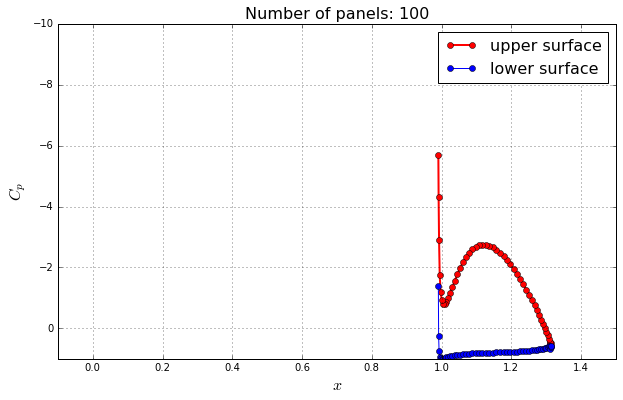

In [26]:
# plot the pressure coefficient 
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in flap_panels if panel.loc=='upper'],
            [panel.cp for panel in flap_panels if panel.loc=='upper'],
           label='upper surface', color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in flap_panels if panel.loc=='lower'],
            [panel.cp for panel in flap_panels if panel.loc=='lower'],
           label='lower surface', color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.5)
pyplot.ylim(1.0, -10.0)
pyplot.title('Number of panels: {}'.format(flap_panels.size), fontsize=16);